# Prediction of Methionine Oxidation Sites

Implementation of the method suggested in https://www.ncbi.nlm.nih.gov/pubmed/28962549

The goal (successful) was to achieve similar results as the paper above. Demonstrational purposes only, not optimized and many things can be improved.


Todo:
 - clean code
 - isolate more code to py modules
 - missing values could be inferred instead of imputed
 - better summary stats for each feature (type and amount of unique values)
 - implement other classification methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('MetOData.csv')
#remove first column from csv since it is only the index
df = df.iloc[:,1:]
df.head()

,ACC,PDB,Met,Oxidable,Yd.chain,Fd.chain,Wd.chain,nY.chain,nF.chain,nW.chain,...,CT_M,CT_N,CT_P,CT_Q,CT_R,CT_S,CT_T,CT_V,CT_W,CT_Y
0,A5YKK6,4C0D,1883,No,10.6,4.8,8.6,0,2,0,...,22.0,37.0,38.0,2.0,14.0,27.0,8.0,24.0,155.0,28.0
1,A5YKK6,4C0D,1905,No,10.9,8.8,12.6,0,0,0,...,22.0,15.0,16.0,9.0,7.0,5.0,21.0,2.0,133.0,6.0
2,A5YKK6,4C0D,1996,No,8.3,11.6,14.2,0,0,0,...,55.0,6.0,8.0,18.0,31.0,47.0,14.0,11.0,42.0,40.0
3,A5YKK6,4C0D,2051,No,6.8,4.8,9.2,1,1,0,...,12.0,30.0,5.0,6.0,29.0,83.0,4.0,31.0,10.0,13.0
4,A5YKK6,4C0D,2063,No,9.8,5.8,10.5,0,1,0,...,25.0,18.0,14.0,3.0,17.0,71.0,22.0,19.0,257.0,1.0


## Extract features (x) and label (y) from original csv

In [3]:
x = df.iloc[:,4:]
x.head()

,Yd.chain,Fd.chain,Wd.chain,nY.chain,nF.chain,nW.chain,numberBonds.chain,closestAro.chain,Yd.pdb,Fd.pdb,...,CT_M,CT_N,CT_P,CT_Q,CT_R,CT_S,CT_T,CT_V,CT_W,CT_Y
0,10.6,4.8,8.6,0,2,0,2,4.8,10.6,4.8,...,22.0,37.0,38.0,2.0,14.0,27.0,8.0,24.0,155.0,28.0
1,10.9,8.8,12.6,0,0,0,0,8.8,10.9,8.8,...,22.0,15.0,16.0,9.0,7.0,5.0,21.0,2.0,133.0,6.0
2,8.3,11.6,14.2,0,0,0,0,8.3,8.3,11.6,...,55.0,6.0,8.0,18.0,31.0,47.0,14.0,11.0,42.0,40.0
3,6.8,4.8,9.2,1,1,0,2,4.8,6.8,4.8,...,12.0,30.0,5.0,6.0,29.0,83.0,4.0,31.0,10.0,13.0
4,9.8,5.8,10.5,0,1,0,1,5.8,9.8,5.8,...,25.0,18.0,14.0,3.0,17.0,71.0,22.0,19.0,257.0,1.0


In [4]:
y = df['Oxidable'].apply(lambda x: x == 'Yes')
y.head()

0    False
1    False
2    False
3    False
4    False
Name: Oxidable, dtype: bool

## Evaluate missing values

dpx             265
fM              237
entropy         237
mean.entropy    237
sd.entropy      237
dtype: int64


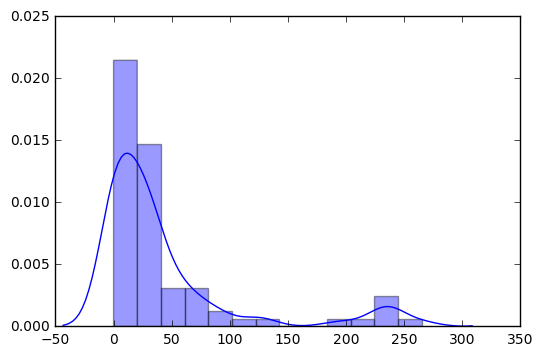

In [5]:
missing = (df.isnull().sum()).sort_values(ascending=False)
print missing.head()
sns.distplot(missing)


## Class balance

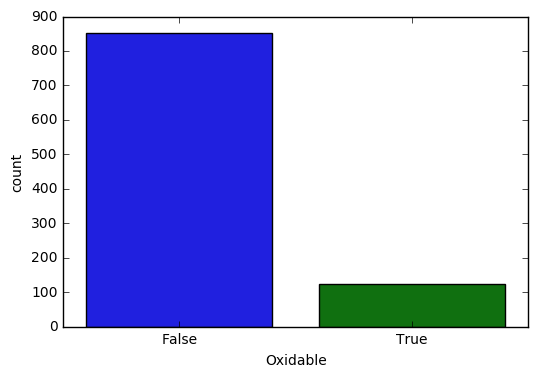

In [6]:
sns.countplot(y)

## Run CV experiments with multiple metrics

In [7]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import scipy



classifier = Pipeline([
        ('imputer', Imputer(strategy='mean')),
        ('rf', RandomForestClassifier(n_estimators=1000, class_weight='balanced'))
    ])

# classifier = Pipeline([
#         ('imputer', Imputer(strategy='mean')),
#         ('rf', RandomForestClassifier(n_estimators=1000))
#     ])

# from sklearn.metrics import matthews_corrcoef, make_scorer

# scoring = {
#     'accuracy': 'accuracy',
# #     'precision_macro': 'precision_macro',
# #     'recall_macro': 'recall_macro',
# #     'f1':'f1',
#     'f1_macro':'f1_macro',
#     'f1_micro':'f1_micro',
#     'mcc':make_scorer(matthews_corrcoef)
# }

# cv_results = cross_validate(classifier, x, y, cv=5, scoring=scoring, verbose=10, return_train_score=False )
# pd.DataFrame(cv_results)

# print np.mean(scores), scipy.stats.norm.interval(0.95, loc=np.mean(scores), scale=np.std(scores))


## Study performance (ROC curve and associated metrics)

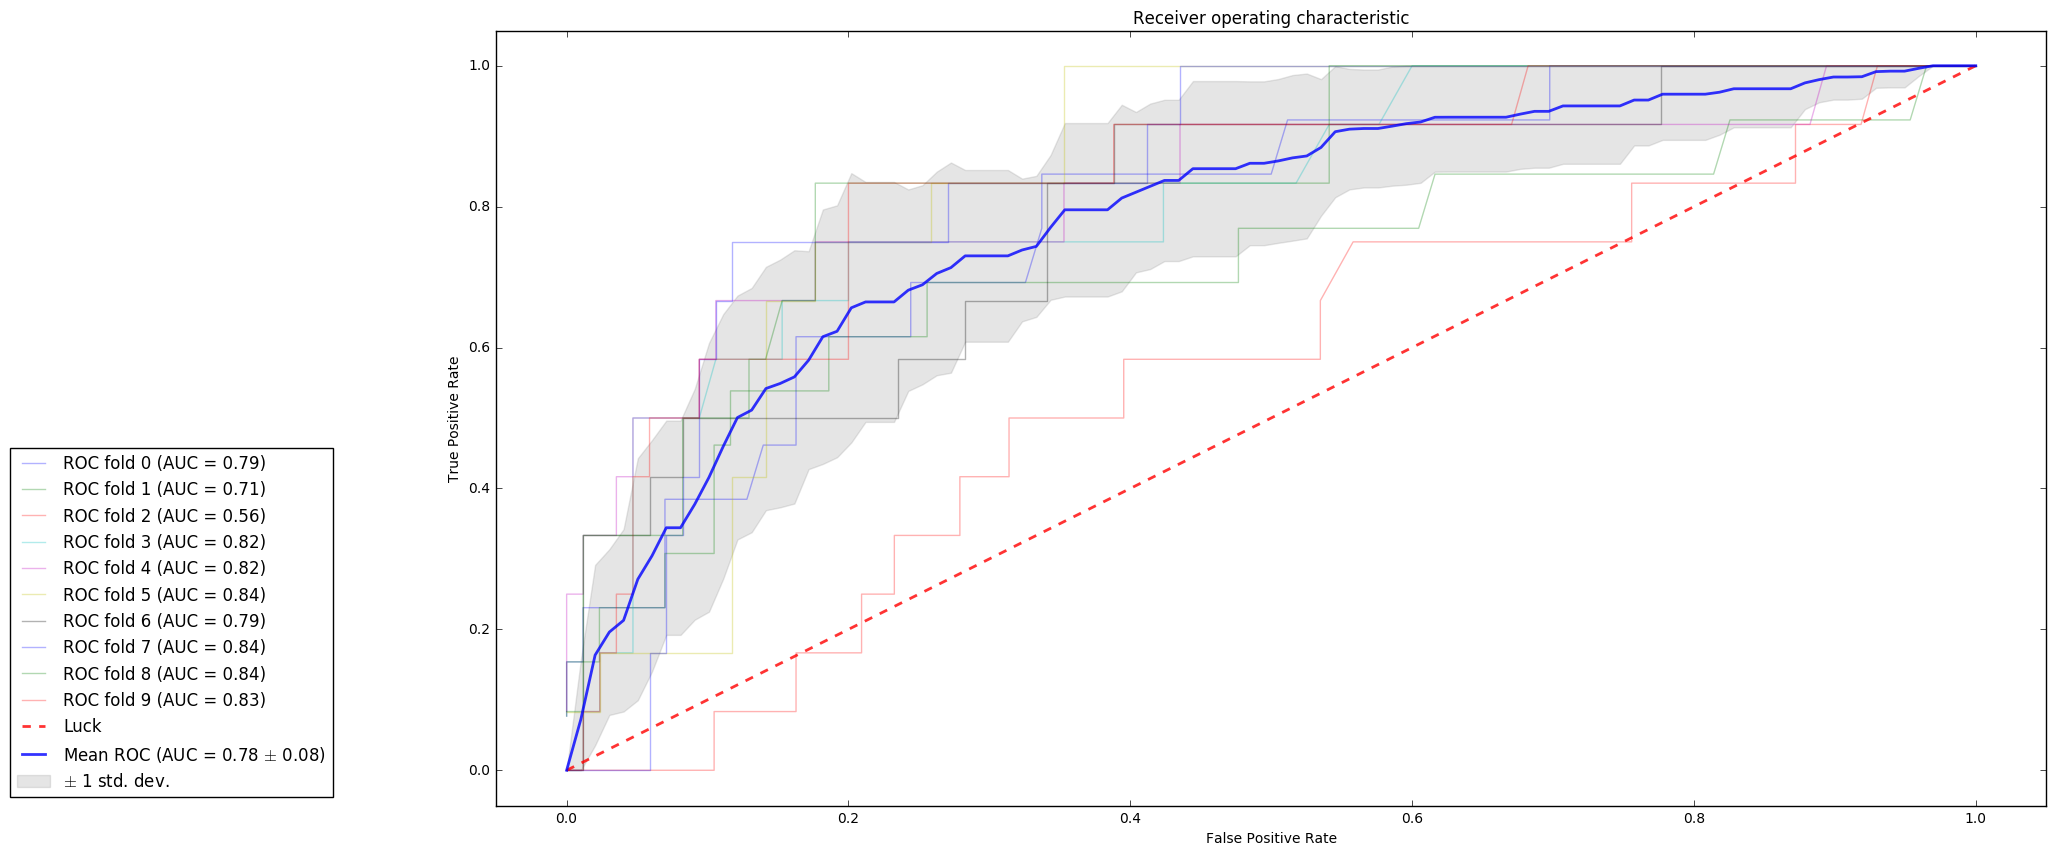

In [8]:
from src.evaluate_model import evaluate_model
from src.class_balance import balance_oversample

from sklearn.preprocessing import FunctionTransformer



# classifier = Pipeline([
#         ('imputer', Imputer(strategy='mean')),
#         ('rf', RandomForestClassifier(n_estimators=1000, class_weight='balanced'))
#     ])

# preprocess_train = None

classifier = Pipeline([
        ('imputer', Imputer(strategy='mean')),
        ('rf', RandomForestClassifier(n_estimators=1000))
    ])

def preprocess_train(x_train, y_train):
    x2raw, y2raw = balance_oversample(x_train.values, y_train.values)    
    x_train_balanced = pd.DataFrame(x2raw, columns=x_train.columns)
    y_train_balanced = pd.Series(y2raw, name=y_train.name)
    return x_train_balanced, y_train_balanced


importances = evaluate_model(x, y, classifier, preprocess_train)

## Study feature importance

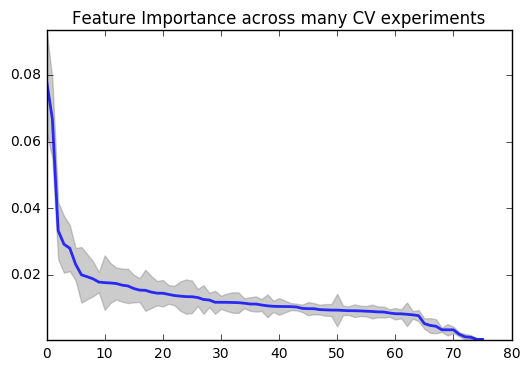

                      max95      mean     min95
SASA.pdb           0.093374  0.078279  0.063184
SASA.chain         0.078617  0.066749  0.054881
CT_Y               0.041779  0.033216  0.024653
Met2Y              0.037655  0.029126  0.020597
NT_M               0.034821  0.027928  0.021036
NT_W               0.027965  0.023112  0.018259
closestAro.pdb     0.028301  0.019936  0.011571
closestAro.chain   0.026141  0.019372  0.012604
Fd.pdb             0.023952  0.018727  0.013502
CT_H               0.020801  0.017757  0.014714
Yd.chain           0.025780  0.017597  0.009414
NT_H               0.023449  0.017493  0.011537
Bfactor            0.022124  0.017327  0.012530
Met2S_PTM          0.021798  0.016842  0.011886
NT_R               0.021740  0.016598  0.011456
Fd.chain           0.019937  0.015822  0.011708
NT_K               0.018939  0.015355  0.011772
Yd.pdb             0.021462  0.015290  0.009118
closest.ptm.chain  0.019582  0.014756  0.009931
CT_I               0.018077  0.014431  0

In [9]:
importance_mean = np.mean(importances, axis=0)
importance_ci = scipy.stats.norm.interval(0.95, loc=importance_mean, scale=np.std(importances, axis=0))
importance_df = pd.DataFrame({
        'mean':importance_mean , 
        'min95':importance_ci[0], 
        'max95':importance_ci[1]}, 
       index=x.columns,
      ).sort_values(by='mean', ascending=False)

plt.ylim([np.min(importance_df['min95']), np.max(importance_df['max95'])])
indexes = range(0,len(importance_df))
plt.plot(indexes, importance_df['mean'], color='b',
         label=r'Mean importance',
         lw=2, alpha=.8)
plt.fill_between(indexes, importance_df['min95'], importance_df['max95'], color='grey', alpha=.4,
                 label=r'$\pm$ 1 std. dev.')
plt.title('Feature Importance across many CV experiments')
plt.show()
print importance_df.head(20)

### Visualize distribution of the most important feature according to label

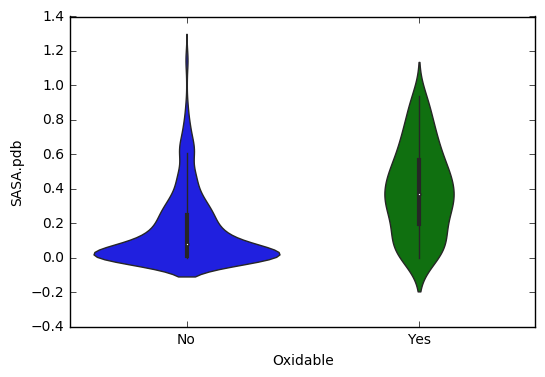

In [10]:
sns.violinplot(x=df['Oxidable'], y=df['SASA.pdb'])